Author : htrf88 <br>
Description : Bias in AI coursework Task 3 implementation

> **Note**
> Plese run notebook cells in order to recreate the output

# Setup

In [1]:
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:,.3f}'.format

Model bias evaluation functions

In [2]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, plot_roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
# from sklearn.metrics import precision_recall_curve, average_precision_score

# Input - X_test_enc (encoded testing data) with true and predicted labels, 
# feature to check bias for and privilaged class in the feature
def check_bias(model, X_test, X_test_enc, y_test, feature, priv_class):
    # Generate the required data for evaluation
    df = X_test.copy()
    df['true'] = y_test
    df['pred'] = model.predict(X_test_enc)
    df['score'] = model.predict_proba(X_test_enc)[:,1]
    
    # Calculate matrics of bias
    print("Checking for bias based on", feature)
    print("Privileged class", priv_class)
    print("-----------------------------------------------")
    # Calculate confusion matrix for privilaged and unprivilaged classes
    priv, unpriv = df[df[feature] == priv_class], df[df[feature] != priv_class]
    TN_p, FP_p, FN_p, TP_p = confusion_matrix(priv.true, priv.pred).ravel()
    TN_u, FP_u, FN_u, TP_u = confusion_matrix(unpriv.true, unpriv.pred).ravel()
    # Calculate metrics of bias
    rate_pos_outcome_p = (TP_p + FP_p)/(TN_p + FP_p + FN_p + TP_p)  # rate of +ve outcome privilaged
    rate_pos_outcome_u = (TP_u + FP_u)/(TN_u + FP_u + FN_u + TP_u)  # rate of +ve outcome unprivilaged
    # Statistical piraty : diff of the rate of +ve outcomes of unprivileged and privileged groups
    stat_piraty = rate_pos_outcome_u - rate_pos_outcome_p
    # Equal oppurtunity : diff of true +ve rates of unprivileged and the privileged groups
    eq_odds_diff = TP_u/(TP_u + FN_u) - TP_p/(TP_p + FN_p)
    # Avg odds diff : average of difference in false +ve rates and true +ve rates between unprivileged 
    # and privileged groups
    avg_odds_diff = ((FP_u/(FP_u + TN_u) - FP_p/(FP_p + TN_p)) + eq_odds_diff)/2
    # Disparate Impact : ratio of prob of +ve outcomes between the unprivileged and privileged group
    disp_impact = rate_pos_outcome_u / rate_pos_outcome_p

    res = pd.DataFrame(index=['Statistical Parity Diff', 'Equal Opportunity Diff', 
                              'Average Odds Diff', 'Disparate Impact'])
    res['value'] = [stat_piraty, eq_odds_diff, avg_odds_diff, disp_impact]
    res['biased'] = [~i for i in [-0.1 < stat_piraty < 0.1, 
                                  -0.1 < eq_odds_diff < 0.1, 
                                  -0.1 < avg_odds_diff < 0.1, 
                                  0.8 < disp_impact < 1.25 ]]
    display(res)
    # Plot ROC curve
    plt.figure(figsize=(10, 4))
    plt.subplot(1,2,1)
    for i in df[feature].unique():
        y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f'{feature} {i} (AUC = %0.2f)'%roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.subplots_adjust(0.125, 0.1, 0.9, 0.9, 0.3, 0.5)
    # Plot precision-recall curve
    plt.subplot(1,2,2)
    legend = []
    for i in df[feature].unique():
        y_true, y_score = df[df[feature] == i].true, df[df[feature] == i].score
        precision, recall, _ = precision_recall_curve(y_true, y_score)
        avg_prec = average_precision_score(y_true, y_score)
        legend.append(f'{feature} {i} (AP = %0.2f)' % avg_prec)
        plt.step(recall, precision, where='post')

    # plt.fill_between(recall, precision, step='post', alpha=0.5, color='orange')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('Precision Recall Curve')
    plt.legend(legend)
    plt.grid(True)
    plt.show()
    print("")

In [3]:
import shap

def shap_summery(model, X_train, X_test):
    explainer = shap.LinearExplainer(clf, X_train)
    shap_values = explainer.shap_values(X_test)
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns)

# Task 3.2 - Data Analysis

## 3.2.1 Load dataset

In [4]:
FEATURES = ["age", "workclass", "fnlwgt", "education", "education_num", "marital_status", "occupation", 
            "relationship", "race", "sex", "capital_gain", "capital_loss", "hours_per_week", "native_country", "salary"]

CONTINUOUS = ['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']
DISCRETE = ["workclass", "education", "marital_status", "occupation", "relationship", "race", "sex", "native_country", 
            "salary"]

data = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/adult-all.csv", 
                   na_values='?', names=FEATURES)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       46043 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education_num   48842 non-null  int64 
 5   marital_status  48842 non-null  object
 6   occupation      46033 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital_gain    48842 non-null  int64 
 11  capital_loss    48842 non-null  int64 
 12  hours_per_week  48842 non-null  int64 
 13  native_country  47985 non-null  object
 14  salary          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


## 3.2.2 Inspect different demographic groups within the data

Distribution of numerical features

In [5]:
num_info = data[CONTINUOUS].describe().transpose()
num_info.drop(columns=['count'], axis=0, inplace=True)
num_info['var'] = [data[i].var() for i in CONTINUOUS]
num_info.transpose()

,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
mean,38.644,"189,664.135",10.078,"1,079.068",87.502,40.422
std,13.711,"105,604.025",2.571,"7,452.019",403.005,12.391
min,17.000,"12,285.000",1.000,0.000,0.000,1.000
25%,28.000,"117,550.500",9.000,0.000,0.000,40.000
50%,37.000,"178,144.500",10.000,0.000,0.000,40.000
75%,48.000,"237,642.000",12.000,0.000,0.000,45.000
max,90.000,"1,490,400.000",16.000,"99,999.000","4,356.000",99.000
var,187.978,"11,152,210,185.575",6.610,"55,532,588.036","162,412.669",153.548


Distribution of selective numerical features with seperated by the outcome of the target variable

In [6]:
continuous = ['age', 'education_num', 'hours_per_week']
data[continuous+['salary']].groupby(['salary']).agg(['count', 'mean', 'std', 'var']).transpose()

salary                    <=50K       >50K
age            count 37,155.000 11,687.000
               mean      36.872     44.275
               std       14.104     10.559
               var      198.926    111.492
education_num  count 37,155.000 11,687.000
               mean       9.598     11.603
               std        2.438      2.383
               var        5.942      5.677
hours_per_week count 37,155.000 11,687.000
               mean      38.840     45.453
               std       12.357     11.091
               var      152.692    123.014

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `sex`

In [7]:
data[continuous+['salary','sex']].groupby(['sex', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

sex                      Female                 Male          
salary                    <=50K      >50K      <=50K      >50K
age            count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      36.279    42.219     37.249    44.642
               std       14.387    10.505     13.909    10.527
               var      206.999   110.352    193.448   110.818
education_num  count 14,423.000 1,769.000 22,732.000 9,918.000
               mean       9.825    11.832      9.455    11.562
               std        2.307     2.202      2.507     2.411
               var        5.322     4.849      6.283     5.814
hours_per_week count 14,423.000 1,769.000 22,732.000 9,918.000
               mean      35.876    40.679     40.721    46.304
               std       11.855    11.854     12.300    10.729
               var      140.542   140.511    151.295   115.117

Distribution of selective numerical variables seperated by outcome of the target variable and protected class `race`

In [8]:
data[continuous+['salary','race']].groupby(['race', 'salary']).agg(['count', 'mean', 'std', 'var']).transpose()

race                 Amer-Indian-Eskimo         ...      White           
salary                            <=50K   >50K  ...      <=50K       >50K
age            count            415.000 55.000  ... 31,155.000 10,607.000
               mean              36.128 40.964  ...     36.929     44.390
               std               12.368  9.469  ...     14.303     10.621
               var              152.957 89.665  ...    204.582    112.803
education_num  count            415.000 55.000  ... 31,155.000 10,607.000
               mean               9.176 10.982  ...      9.629     11.603
               std                2.151  2.198  ...      2.433      2.373
               var                4.628  4.833  ...      5.919      5.630
hours_per_week count            415.000 55.000  ... 31,155.000 10,607.000
               mean              39.817 43.709  ...     38.995     45.552
               std               12.256  8.956  ...     12.627     11.160
               var              150.213 80.210  ...    159.446    124.545

[12 rows x 10 columns]

Analysing categorical data

In [9]:
for i in DISCRETE[:-1]:
    print("Demographic group: ", i)
    print("3 most frequent values: " + ', '.join(data[i].value_counts()[:3].index.tolist()))
    unq = data[i].unique()
    info = pd.DataFrame(columns=["Count"], index=unq)
    info["Count"] = [data[data[i] == j].shape[0] for j in unq]
    info[">50K (%)"] = [data[(data[i] == j) & (data.salary == '>50K')].shape[0] for j in unq]
    info[">50K (%)"] = np.round(info[">50K (%)"]/info["Count"], 3)
    info = info.sort_values(by=['>50K (%)'], ascending=False)
    print("Population size and % of population earning >50K a year for this demographic as described below")
    display(info.transpose())
    print("")


Demographic group:  workclass
3 most frequent values: Private, Self-emp-not-inc, Local-gov
Population size and % of population earning >50K a year for this demographic as described below


,Self-emp-inc,Federal-gov,Local-gov,Self-emp-not-inc,State-gov,Private,Without-pay,Never-worked,NaN
Count,"1,695.000","1,432.000","3,136.000","3,862.000","1,981.000","33,906.000",21.000,10.000,0.000
>50K (%),0.553,0.392,0.296,0.279,0.268,0.218,0.095,0.000,nan



Demographic group:  education
3 most frequent values: HS-grad, Some-college, Bachelors
Population size and % of population earning >50K a year for this demographic as described below


,Prof-school,Doctorate,Masters,Bachelors,Assoc-acdm,Assoc-voc,Some-college,HS-grad,12th,7th-8th,10th,9th,5th-6th,11th,1st-4th,Preschool
Count,834.000,594.000,"2,657.000","8,025.000","1,601.000","2,061.000","10,878.000","15,784.000",657.000,955.000,"1,389.000",756.000,509.000,"1,812.000",247.000,83.000
>50K (%),0.740,0.726,0.549,0.413,0.258,0.253,0.190,0.159,0.073,0.065,0.063,0.054,0.053,0.051,0.032,0.012



Demographic group:  marital_status
3 most frequent values: Married-civ-spouse, Never-married, Divorced
Population size and % of population earning >50K a year for this demographic as described below


,Married-civ-spouse,Married-AF-spouse,Divorced,Married-spouse-absent,Widowed,Separated,Never-married
Count,"22,379.000",37.000,"6,633.000",628.000,"1,518.000","1,530.000","16,117.000"
>50K (%),0.446,0.378,0.101,0.092,0.084,0.065,0.045



Demographic group:  occupation
3 most frequent values: Prof-specialty, Craft-repair, Exec-managerial
Population size and % of population earning >50K a year for this demographic as described below


,Exec-managerial,Prof-specialty,Armed-Forces,Protective-serv,Tech-support,Sales,Craft-repair,Transport-moving,Adm-clerical,Machine-op-inspct,Farming-fishing,Handlers-cleaners,Other-service,Priv-house-serv,NaN
Count,"6,086.000","6,172.000",15.000,983.000,"1,446.000","5,504.000","6,112.000","2,355.000","5,611.000","3,022.000","1,490.000","2,072.000","4,923.000",242.000,0.000
>50K (%),0.478,0.451,0.333,0.313,0.290,0.268,0.226,0.204,0.137,0.123,0.116,0.067,0.041,0.012,nan



Demographic group:  relationship
3 most frequent values: Husband, Not-in-family, Own-child
Population size and % of population earning >50K a year for this demographic as described below


,Wife,Husband,Not-in-family,Unmarried,Other-relative,Own-child
Count,"2,331.000","19,716.000","12,583.000","5,125.000","1,506.000","7,581.000"
>50K (%),0.469,0.449,0.101,0.060,0.035,0.015



Demographic group:  race
3 most frequent values: White, Black, Asian-Pac-Islander
Population size and % of population earning >50K a year for this demographic as described below


,Asian-Pac-Islander,White,Other,Black,Amer-Indian-Eskimo
Count,"1,519.000","41,762.000",406.000,"4,685.000",470.000
>50K (%),0.269,0.254,0.123,0.121,0.117



Demographic group:  sex
3 most frequent values: Male, Female
Population size and % of population earning >50K a year for this demographic as described below


,Male,Female
Count,"32,650.000","16,192.000"
>50K (%),0.304,0.109



Demographic group:  native_country
3 most frequent values: United-States, Mexico, Philippines
Population size and % of population earning >50K a year for this demographic as described below


,France,India,Taiwan,Iran,England,Greece,Yugoslavia,Japan,Canada,Italy,Cambodia,Hungary,Ireland,China,Philippines,Germany,Hong,Cuba,United-States,Poland,Portugal,South,Thailand,Scotland,Jamaica,Ecuador,Haiti,Puerto-Rico,Honduras,Laos,Peru,Vietnam,Trinadad&Tobago,El-Salvador,Nicaragua,Mexico,Dominican-Republic,Columbia,Outlying-US(Guam-USVI-etc),Guatemala,Holand-Netherlands,NaN
Count,38.000,151.000,65.000,59.000,127.000,49.000,23.000,92.000,182.000,105.000,28.000,19.000,37.000,122.000,295.000,206.000,30.000,138.000,"43,832.000",87.000,67.000,115.000,30.000,21.000,106.000,45.000,75.000,184.000,20.000,23.000,46.000,86.000,27.000,155.000,49.000,951.000,103.000,85.000,23.000,88.000,1.000,0.000
>50K (%),0.421,0.411,0.400,0.373,0.370,0.367,0.348,0.348,0.346,0.324,0.321,0.316,0.297,0.295,0.288,0.282,0.267,0.246,0.244,0.195,0.179,0.174,0.167,0.143,0.142,0.133,0.120,0.109,0.100,0.087,0.087,0.081,0.074,0.071,0.061,0.049,0.049,0.047,0.043,0.034,0.000,nan


# Task 3.3 - Conventional implementation

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## Data preparation for ML 

In [11]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)

In [12]:
# Removing anomalies form the data
# Removing individual of age over 80 years working full time because it is highly unsual
data = data[~((data['age'] >= 80) & (data['hours_per_week'] >= 20))]
data.shape

(45111, 15)

In [13]:
# Encode native-country, salary and race
data['native_country'] = data['native_country'].apply(lambda x: 1 if x == "United-States" else 0)
data['salary'] = data['salary'].map(lambda x : 1 if x == '>50K' else 0)
data['race'] = data['race'].apply(lambda x: "White" if x == "White" else "non-White")


# Encode marital-status
data['marital_status'] = data['marital_status'].replace(
    ['Divorced','Married-spouse-absent','Never-married','Separated','Widowed'], 0)
data['marital_status'] = data['marital_status'].replace(['Married-AF-spouse','Married-civ-spouse'], 1)


# Simplify workclass
def workclass(x):
    if 'gov' in x:
        return 'gov'
    elif x == 'Private':
        return 'private'
    elif x == 'Self-emp-inc':
        return 'self_employed'
    else:
        return 'without_pay'

data['workclass'] = data['workclass'].apply(workclass)


# Simplify occupation
def occupation(x):
    if x in ['Adm-clerical', 'Exec-managerial']:
        return 'White-Collar'
    elif x in ['Craft-repair', 'Farming-fishing', 'Handlers-cleaners', 'Machine-op-inspct', 'Transport-moving']:
        return 'Blue-Collar'
    elif x in ['Other-service', 'Priv-house-serv', 'Protective-serv', 'Tech-support']:
        return 'Service'
    elif x == 'Prof-specialty':
        return 'Professional'
    else:
        return x

data['occupation'] = data['occupation'].apply(occupation)


# Encode capital_gain and capital_loss
data['capital_gain'] = data['capital_gain'].map(lambda x: 1 if x > 0 else 0)
data['capital_loss'] = data['capital_loss'].map(lambda x: 1 if x > 0 else 0)
CONTINUOUS.remove('capital_gain')
CONTINUOUS.remove('capital_loss')
DISCRETE += ['capital_gain', 'capital_loss']


# Normalize continuous features
data[CONTINUOUS] = (data[CONTINUOUS] - data[CONTINUOUS].mean())/data[CONTINUOUS].std()

data = data.drop(['education'], axis=1)
data

,age,workclass,fnlwgt,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,salary
0,0.043,gov,-1.062,1.129,0,White-Collar,Not-in-family,White,Male,1,0,-0.079,1,0
1,0.888,without_pay,-1.008,1.129,1,White-Collar,Husband,White,Male,0,0,-2.329,1,0
2,-0.033,private,0.245,-0.439,0,Blue-Collar,Not-in-family,White,Male,0,0,-0.079,1,0
3,1.118,private,0.425,-1.224,1,Blue-Collar,Husband,non-White,Male,0,0,-0.079,1,0
4,-0.801,private,1.406,1.129,1,Professional,Wife,non-White,Female,0,0,-0.079,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,-0.417,private,0.524,1.129,0,Professional,Own-child,White,Male,0,0,-0.079,1,0
45218,0.043,private,0.242,1.129,0,Professional,Not-in-family,White,Female,0,0,-0.412,1,0
45219,-0.033,private,1.752,1.129,1,Professional,Husband,White,Male,0,0,0.754,1,0
45220,0.427,private,-1.002,1.129,0,White-Collar,Own-child,non-White,Male,1,0,-0.079,1,0


## 3.3.2 Naively splitting the dataset into training and testing dataset

In [14]:
enc_columns = ['workclass', 'occupation', 'relationship', 'sex', 'race']
X = data.drop(['salary'], axis=1)
y = data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)
X_train_enc = pd.get_dummies(X_train, columns=enc_columns, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=enc_columns, drop_first=True)

## 3.3.3 Training, test and evaluate model

In [15]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train_enc, y_train)
print(classification_report(y_test, clf.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11168
           1       0.71      0.58      0.64      3719

    accuracy                           0.84     14887
   macro avg       0.79      0.75      0.77     14887
weighted avg       0.83      0.84      0.83     14887



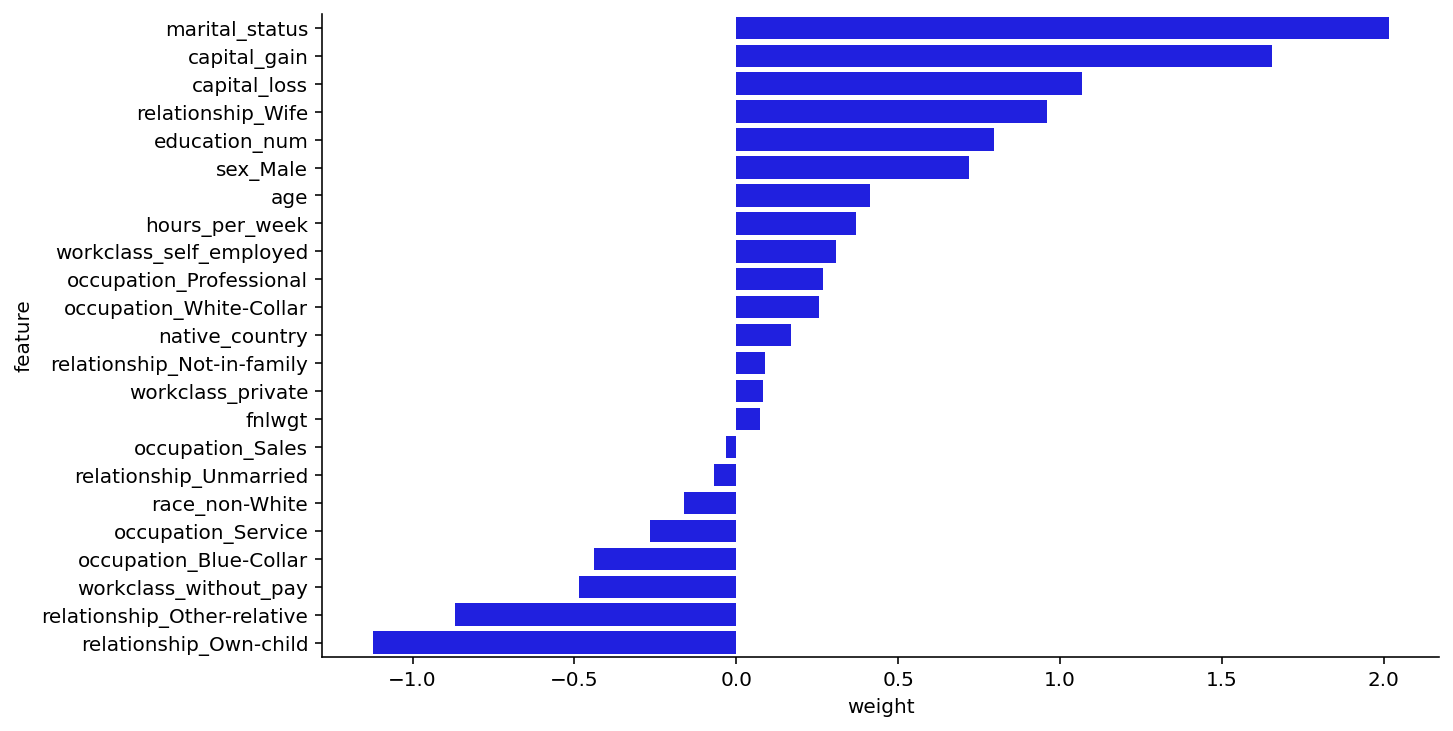

In [16]:
feat_imp = pd.DataFrame(clf.coef_[0], columns=['weight'])
feat_imp['feature'] = X_test_enc.columns
feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", color='b', aspect=2, height=5)

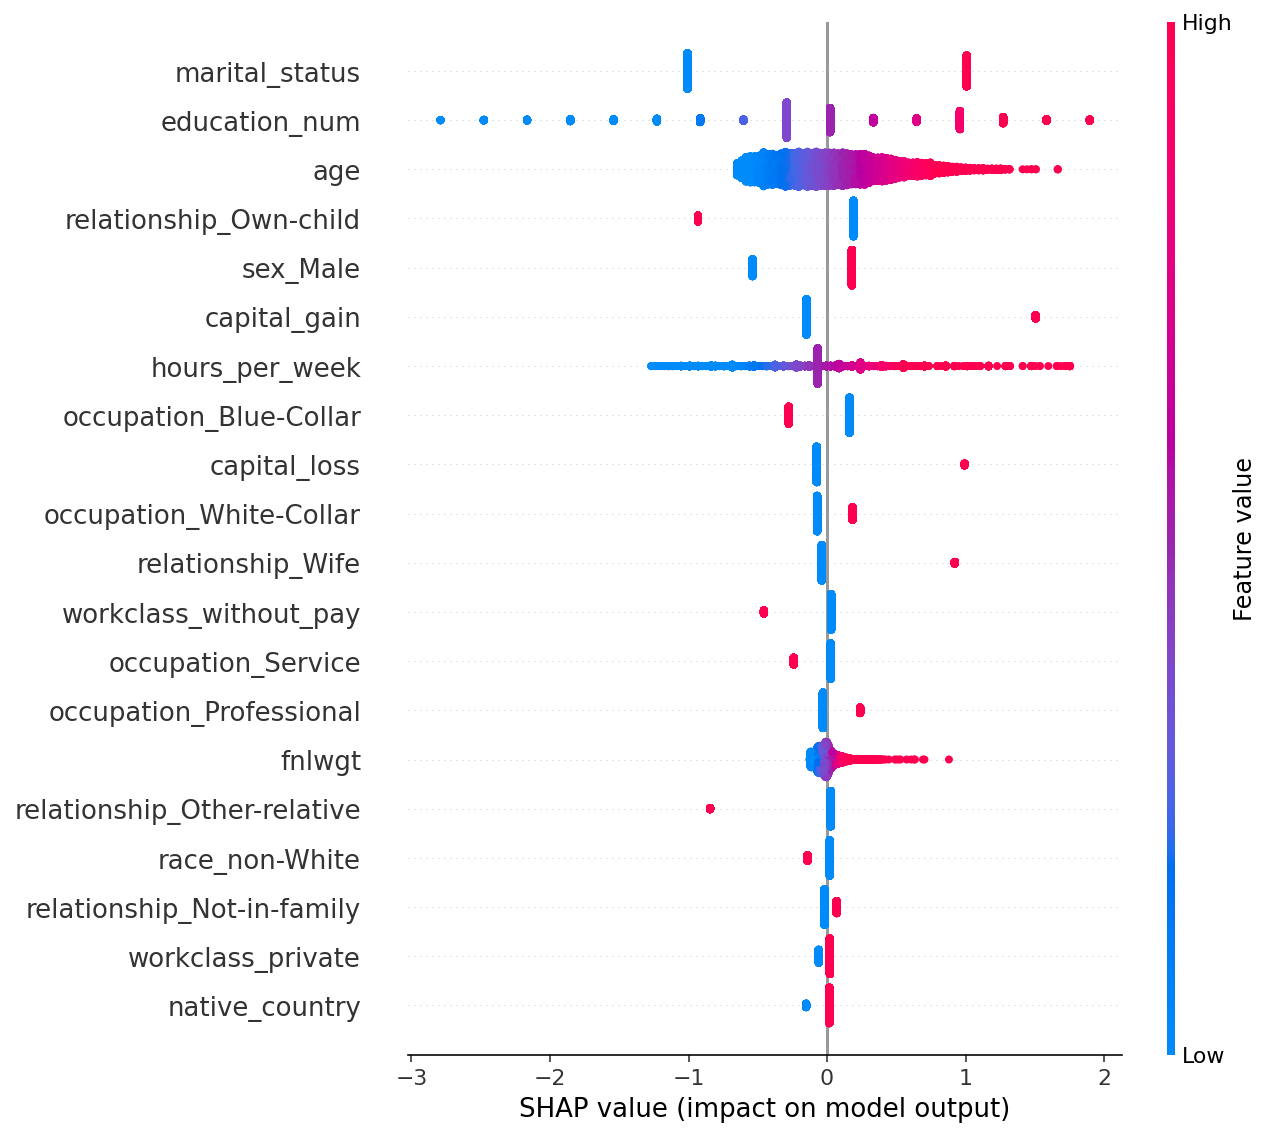

In [17]:
shap_summery(clf, X_test_enc, X_test_enc)

In [18]:
# rfc = RandomForestClassifier(max_depth=20, random_state=42)
# rfc.fit(X_train_enc, y_train)

# feat_imp = pd.DataFrame(rfc.feature_importances_, columns=['weight'])
# feat_imp['feature'] = X_train_enc.columns
# feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
# sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", 
# 			color="b", aspect=1.8, height=8)

Checking for bias in the conventional model

Checking for bias based on race
Privileged class White
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.111,True
Equal Opportunity Diff,-0.102,True
Average Odds Diff,-0.073,False
Disparate Impact,0.497,True


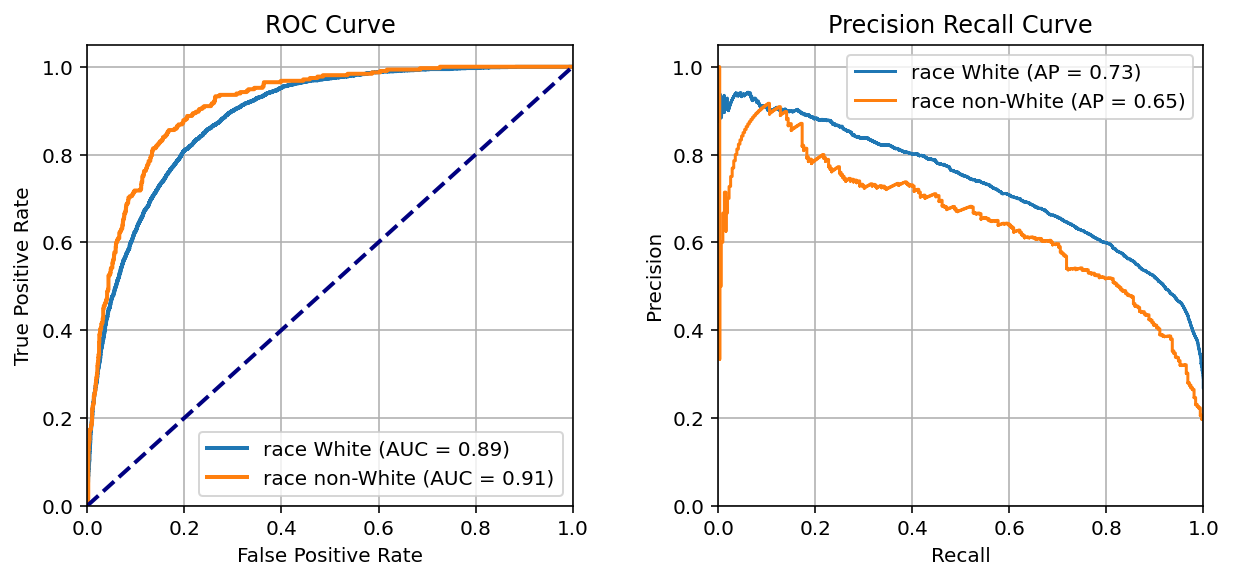


Checking for bias based on sex
Privileged class Male
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.194,True
Equal Opportunity Diff,-0.130,True
Average Odds Diff,-0.109,True
Disparate Impact,0.278,True


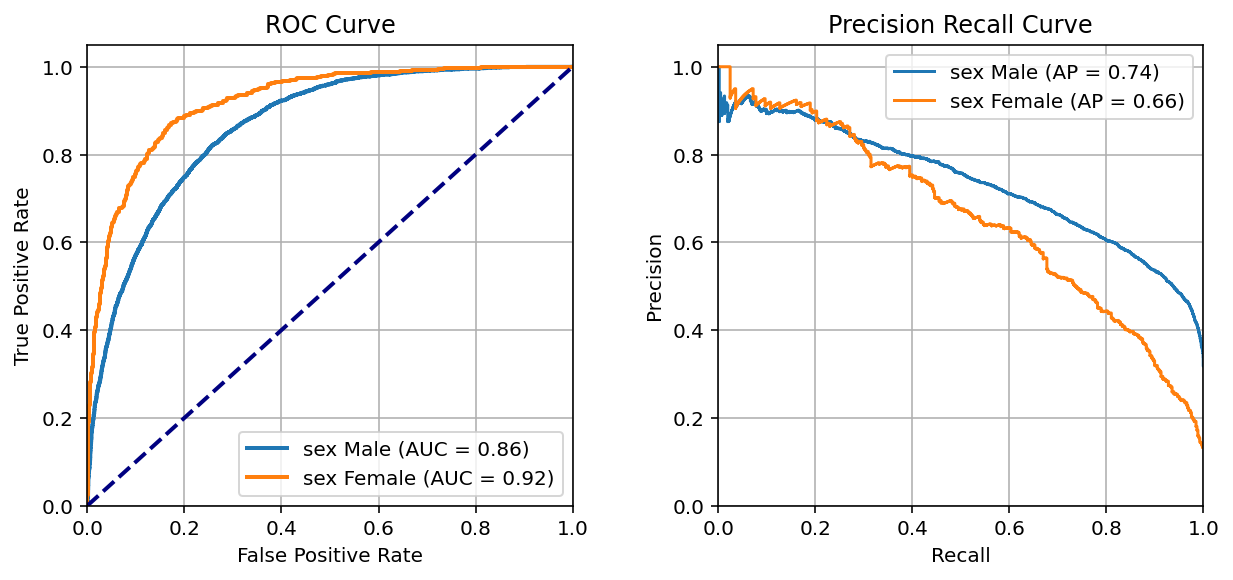

In [19]:
check_bias(clf, X_test, X_test_enc, y_test, "race", "White")
check_bias(clf, X_test, X_test_enc, y_test, "sex", "Male")
# check_bias(clf, X_test, X_test_enc, y_test, "native_country", 1)

## 3.3.4 Unbiased split of the data into training and testing set

In [20]:
data['demo_groups'] = data['sex'] + data['race'].astype(str) + data['salary'].astype(str)
X = data.drop(['salary'], axis=1)
y = data['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True,
                                                    stratify=data.demo_groups)

# Drop the demo_group column from X_test and X_train as it's not required
X_train = X_train.drop(['demo_groups'], axis=1)
X_test = X_test.drop(['demo_groups'], axis=1)

X_train_enc = pd.get_dummies(X_train, columns=enc_columns, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=enc_columns, drop_first=True)

In [21]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train_enc, y_train)
print(classification_report(y_test, clf.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.87      0.92      0.89     11196
           1       0.71      0.57      0.63      3691

    accuracy                           0.84     14887
   macro avg       0.79      0.75      0.76     14887
weighted avg       0.83      0.84      0.83     14887



Checking for bias based on race
Privileged class White
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.103,True
Equal Opportunity Diff,-0.095,False
Average Odds Diff,-0.069,False
Disparate Impact,0.512,True


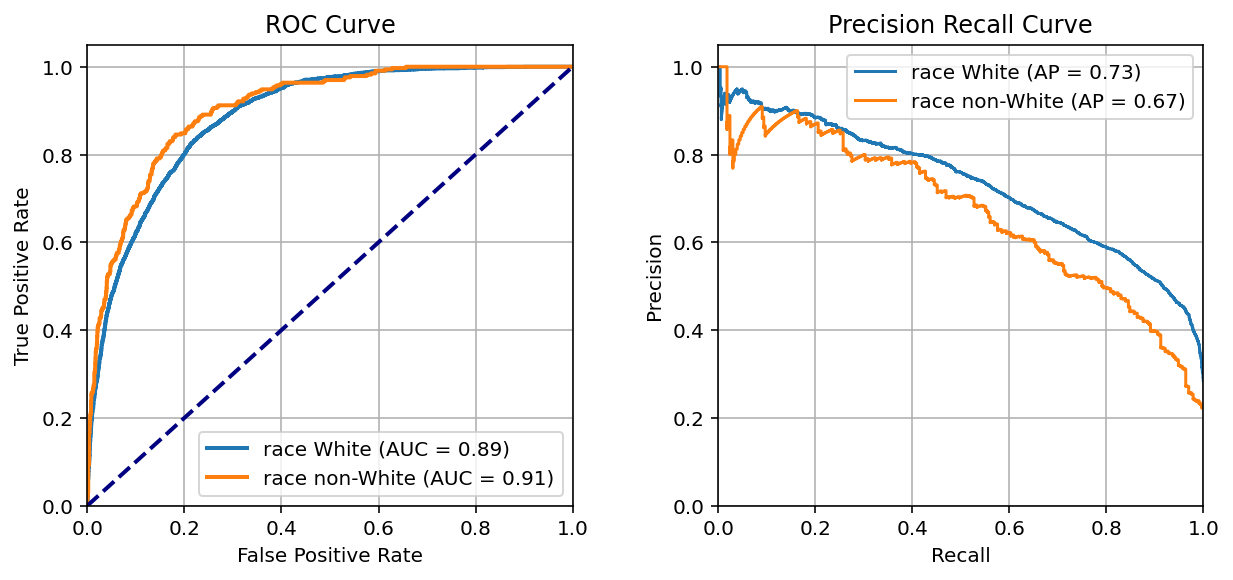


Checking for bias based on sex
Privileged class Male
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.201,True
Equal Opportunity Diff,-0.200,True
Average Odds Diff,-0.146,True
Disparate Impact,0.234,True


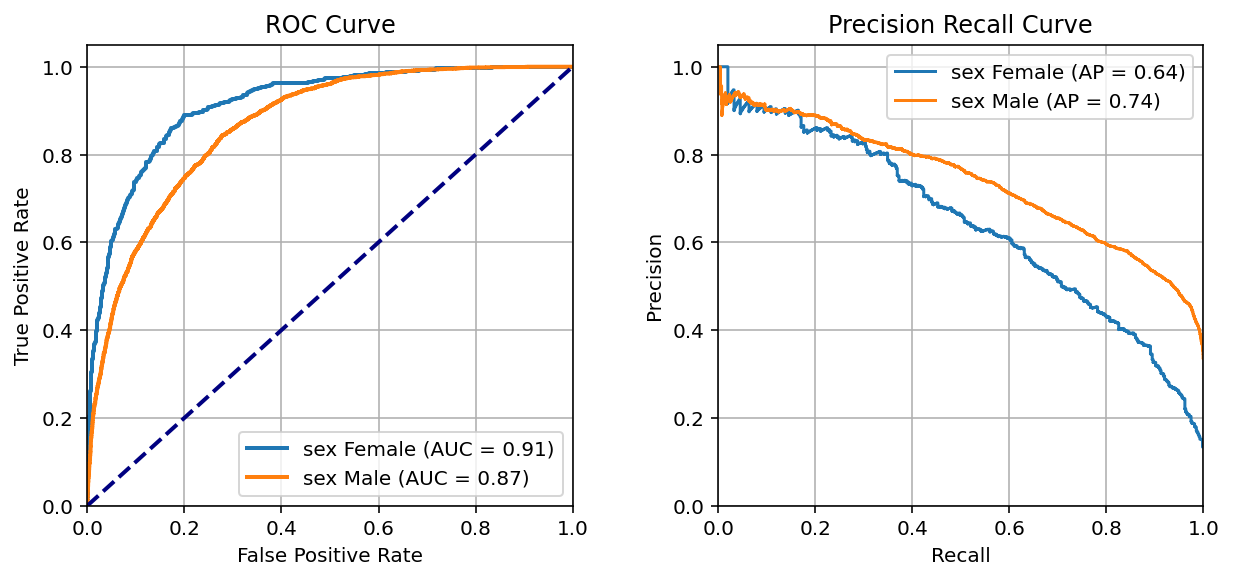

In [22]:
check_bias(clf, X_test, X_test_enc, y_test, "race", "White")
check_bias(clf, X_test, X_test_enc, y_test, "sex", "Male")
# check_bias(clf, X_test, X_test_enc, y_test, "native_country", 1)

# Task 3.4 Fair machine learning implementation

Uniform Sampling
- Deprived groups - Female and/or non-White
- Favored groups - Male and/or White
- Positive label - `salary == 1`
- Negative label - `salary == 0`

In [23]:
data.demo_groups.value_counts()

MaleWhite0          18214
FemaleWhite0        10404
MaleWhite1           8733
Malenon-White0       2712
Femalenon-White0     2596
FemaleWhite1         1452
Malenon-White1        786
Femalenon-White1      214
Name: demo_groups, dtype: int64

Here
- Deprived groups with positive labels - `'FemaleWhite1', 'Malenon-White1', 'Femalenon-White1'`
- Deprived groups with negative labels - `'FemaleWhite0', 'Malenon-White0', 'Femalenon-White0'`
- Favoured groups with positive labels - `'MaleWhite1'`
- Favoured groups with negative labels - `'MaleWhite0'`

In [24]:
# Split data while preserving the proportions of the 8 demographic groups stated above
uniform_sample = data.groupby('demo_groups').apply(lambda x: x.sample(data.shape[0], replace=True))
X = uniform_sample.drop(['salary'], axis=1)
y = uniform_sample['salary']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True,
                                                    stratify=uniform_sample.demo_groups)

# Drop the demo_group column from X_test and X_train as it's not required
X_train = X_train.drop(['demo_groups'], axis=1)
X_test = X_test.drop(['demo_groups'], axis=1)

# One hot encoding catgorical features
X_train_enc = pd.get_dummies(X_train, columns=enc_columns, drop_first=True)
X_test_enc = pd.get_dummies(X_test, columns=enc_columns, drop_first=True)

In [25]:
clf = LogisticRegression(random_state=42, max_iter=500)
clf.fit(X_train_enc, y_train)
print(classification_report(y_test, clf.predict(X_test_enc)))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82     59548
           1       0.82      0.82      0.82     59546

    accuracy                           0.82    119094
   macro avg       0.82      0.82      0.82    119094
weighted avg       0.82      0.82      0.82    119094



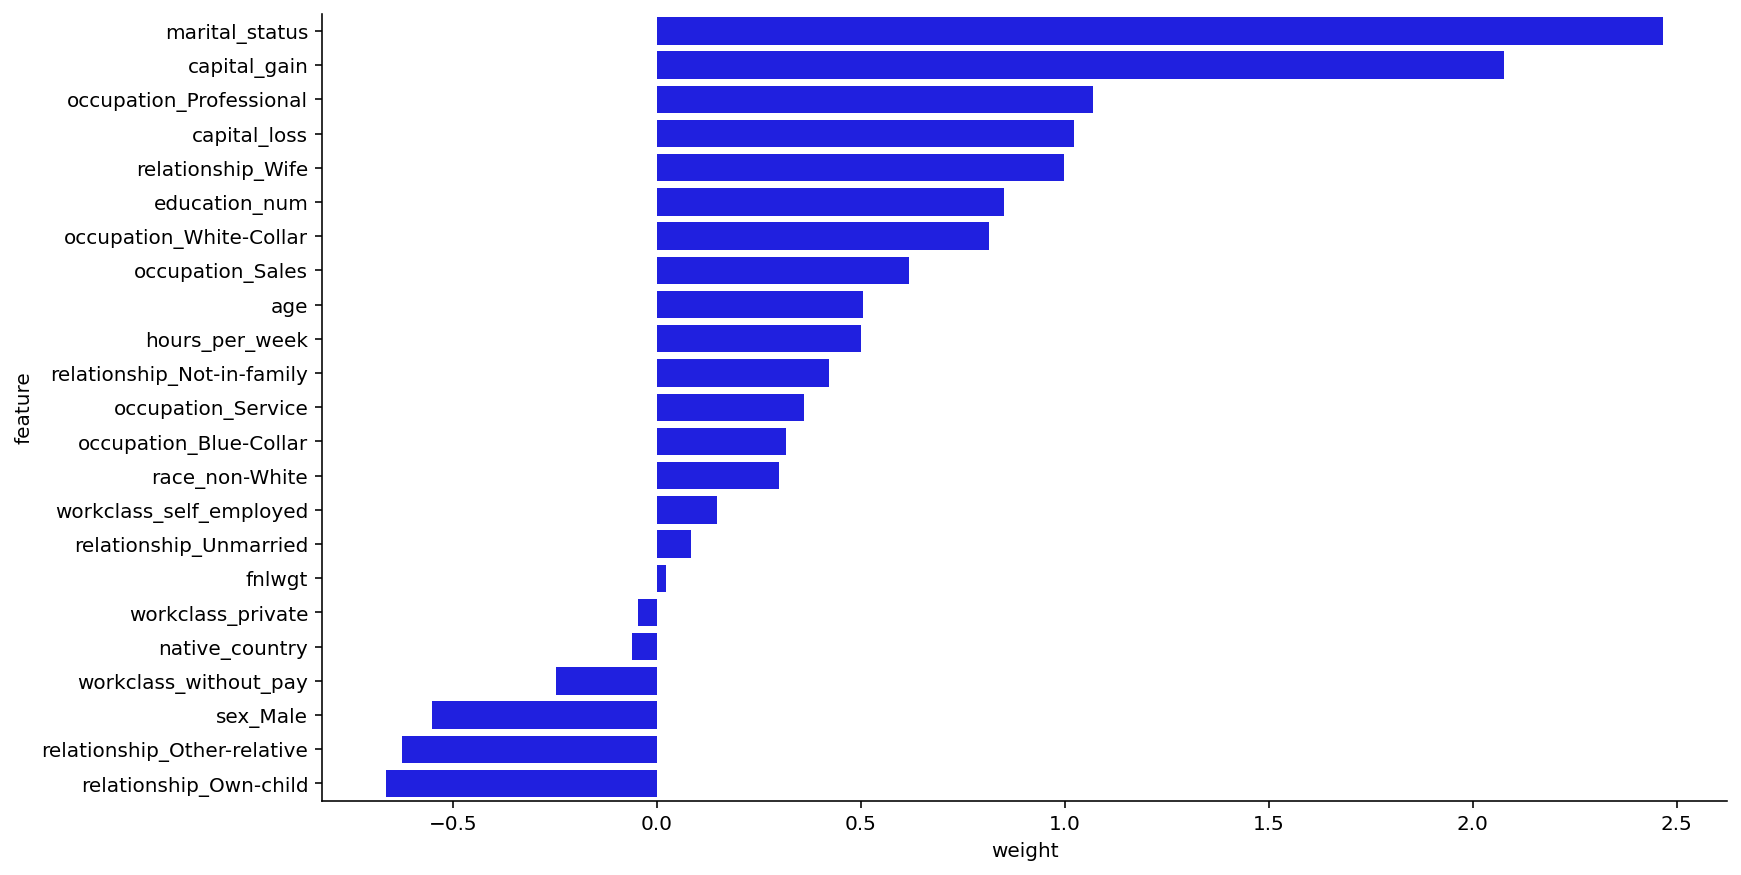

In [26]:
feat_imp = pd.DataFrame(clf.coef_[0], columns=['weight'])
feat_imp['feature'] = X_test_enc.columns
feat_imp = feat_imp.sort_values(by=['weight'], ascending=False)
sns.catplot(x="weight", y="feature", data=feat_imp, kind="bar", color='b', aspect=2, height=6)

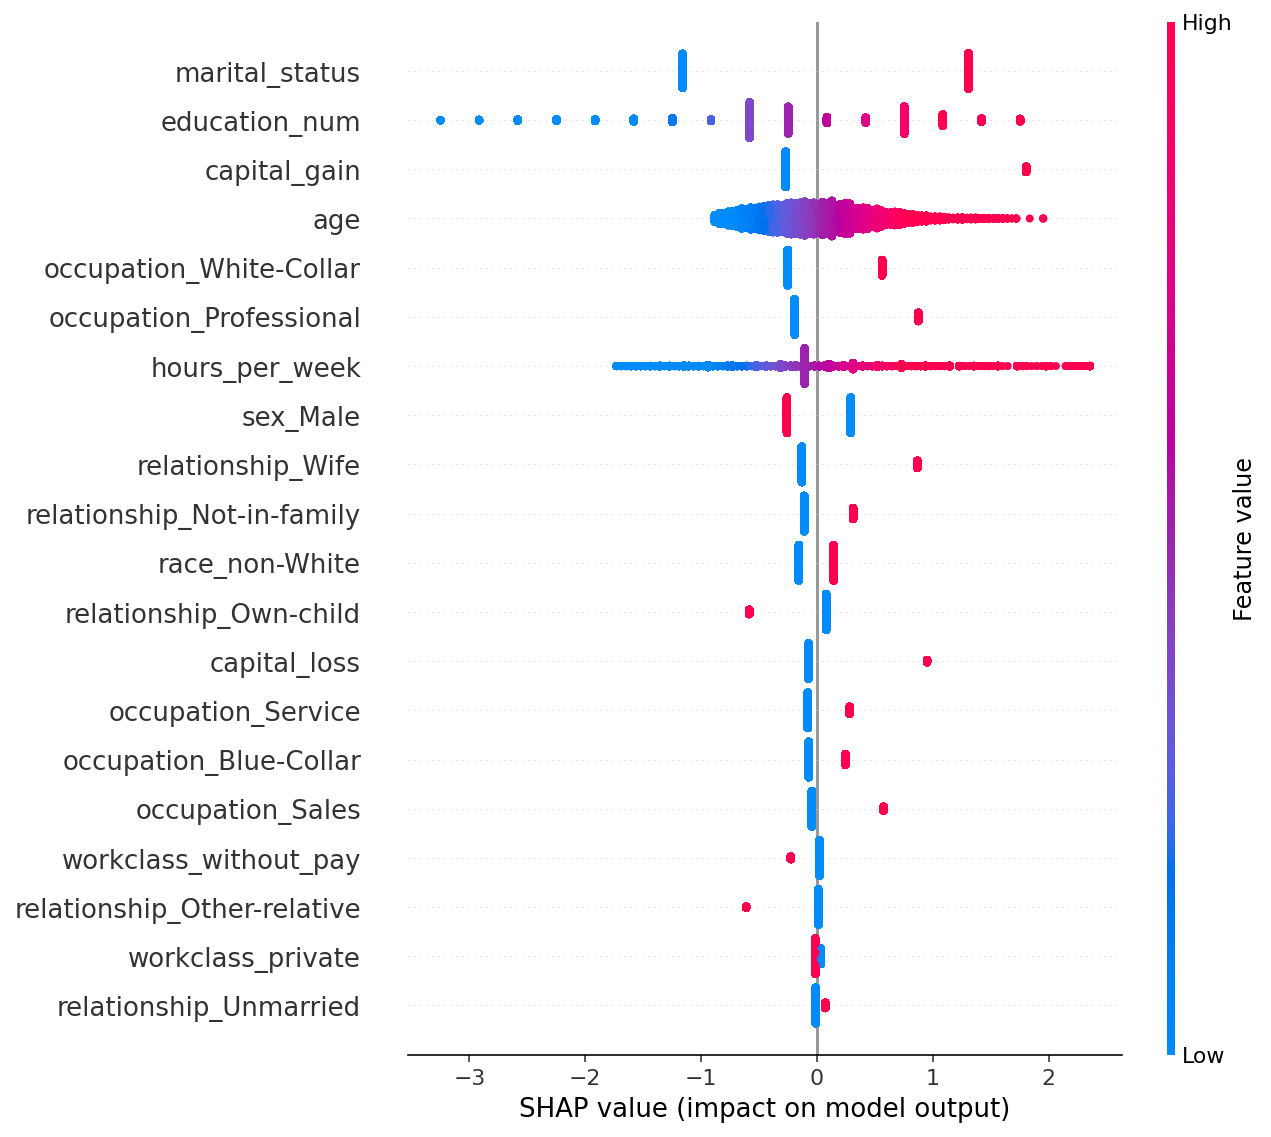

In [27]:
shap_summery(clf, X_train_enc, X_test_enc)

Checking for bias based on race
Privileged class White
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.004,False
Equal Opportunity Diff,0.017,False
Average Odds Diff,-0.004,False
Disparate Impact,0.991,False


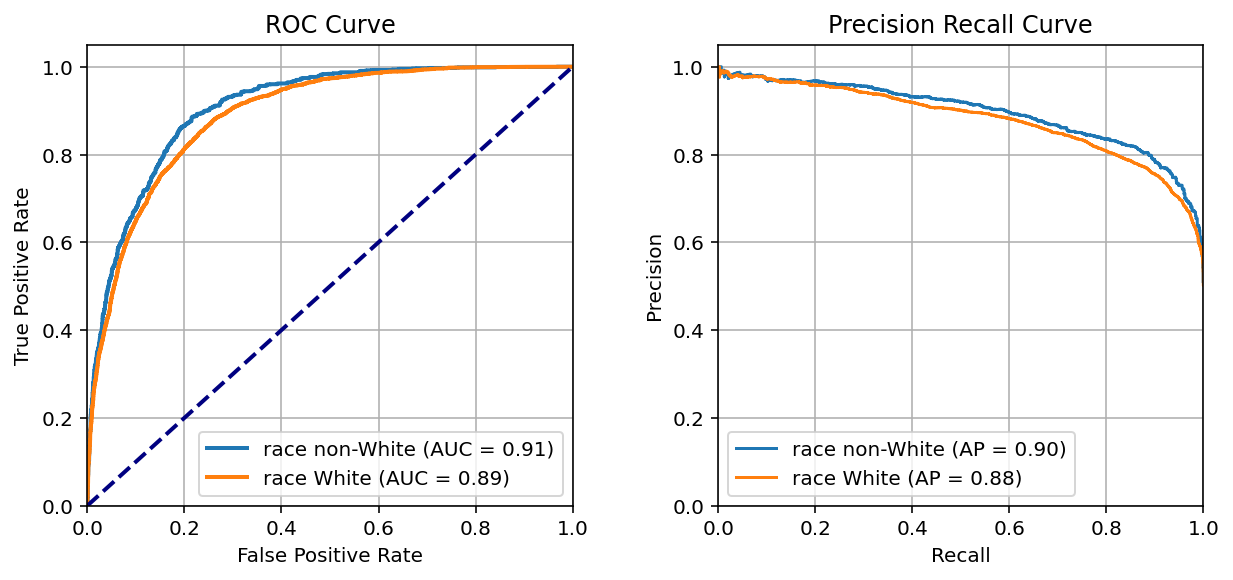


Checking for bias based on sex
Privileged class Male
-----------------------------------------------


,value,biased
Statistical Parity Diff,-0.024,False
Equal Opportunity Diff,0.021,False
Average Odds Diff,-0.024,False
Disparate Impact,0.953,False


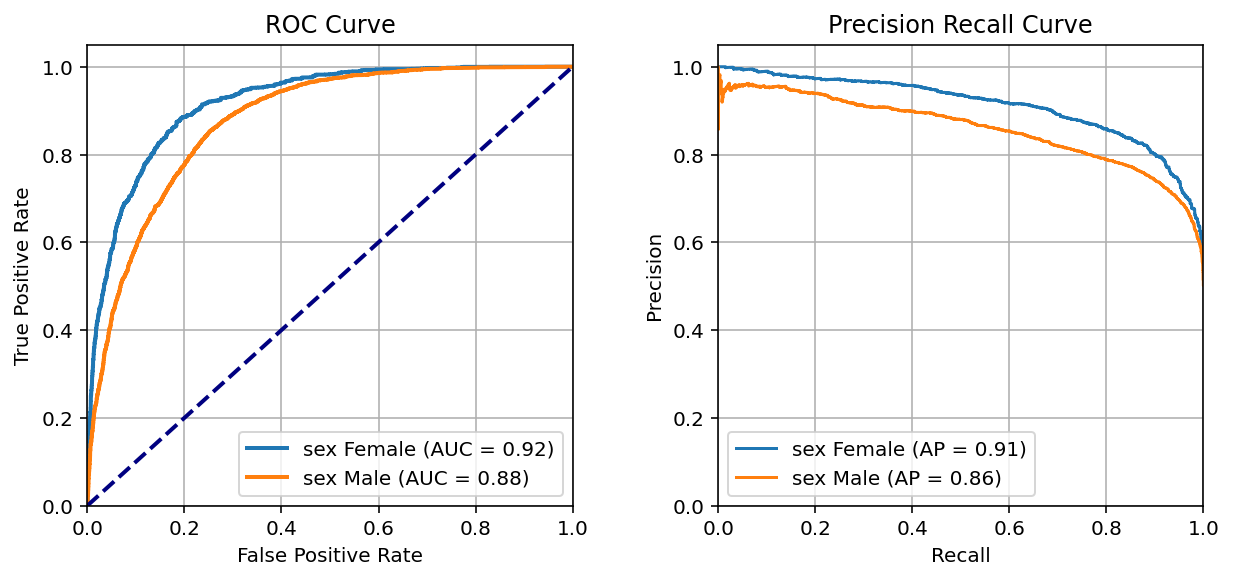

In [28]:
check_bias(clf, X_test, X_test_enc, y_test, "race", "White")
check_bias(clf, X_test, X_test_enc, y_test, "sex", "Male")
# check_bias(clf, X_test, X_test_enc, y_test, "native_country", 1)